# Analysis of Yelp Business Intelligence Data

We will analyze a subset of Yelp's business, reviews and user data. This dataset comes to us from [Kaggle](https://www.kaggle.com/yelp-dataset/yelp-dataset) although we have taken steps to pull this data into a publis s3 bucket: `s3://sta9760-yelpdataset/yelp-light/*business.json`

In [1]:
%info

# Installation and Initial Setup

Begin by installing the necessary libraries that you may need to conduct your analysis. At the very least, you must install `pandas` and `matplotlib`

In [2]:
sc.install_pypi_package("pandas==1.0.3")
sc.install_pypi_package("matplotlib==3.2.1")
sc.install_pypi_package("seaborn==0.10.0")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Importing

Now, import the installed packages from the previous block below.

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Loading Data

We are finally ready to load data. Using `spark` load the data from S3 into a `dataframe` object that we can manipulate further down in our analysis.

In [4]:
business = spark.read.json('s3://sta9760f2020-project2-review-dataset/yelp_academic_dataset_business.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Overview of Data

Display the number of rows and columns in our dataset.

In [5]:
print(f' Columns: {len(business.dtypes)} |  Rows: {business.count():}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

 Columns: 14 |  Rows: 209393

Display the DataFrame schema below.

In [6]:
business.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

Display the first 5 rows with the following columns:

* `business_id`
* `name`
* `city`
* `state`
* `categories`

In [7]:
#df.select('business_id','name','city','state','stars','categories').show(5, truncate=True)
business.createOrReplaceTempView('YelpBusiness')
sqldf = spark.sql(
'''
SELECT `business_id`, `name`, `city`, `state`, `stars`,`categories`
FROM YelpBusiness

'''
)
sqldf.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+---------------+-----+-----+--------------------+
|         business_id|                name|           city|state|stars|          categories|
+--------------------+--------------------+---------------+-----+-----+--------------------+
|f9NumwFMBDn751xgF...|The Range At Lake...|      Cornelius|   NC|  3.5|Active Life, Gun/...|
|Yzvjg0SayhoZgCljU...|   Carlos Santo, NMD|     Scottsdale|   AZ|  5.0|Health & Medical,...|
|XNoUzKckATkOD1hP6...|             Felinus|       Montreal|   QC|  5.0|Pets, Pet Service...|
|6OAZjbxqM5ol29BuH...|Nevada House of Hose|North Las Vegas|   NV|  2.5|Hardware Stores, ...|
|51M2Kk903DFYI6gnB...|USE MY GUY SERVIC...|           Mesa|   AZ|  4.5|Home Services, Pl...|
+--------------------+--------------------+---------------+-----+-----+--------------------+
only showing top 5 rows

# Analyzing Categories

Let's now answer this question: **how many unique categories are represented in this dataset?**

Essentially, we have the categories per business as a list - this is useful to quickly see what each business might be represented as but it is difficult to easily answer questions such as:

* How many businesses are categorized as `Active Life`, for instance
* What are the top 20 most popular categories available?

## Association Table

We need to "break out" these categories from the business ids? One common approach to take is to build an association table mapping a single business id multiple times to each distinct category.

For instance, given the following:


| business_id | categories |
|-------------|------------|
| abcd123     | a,b,c      |

We would like to derive something like:

| business_id | category |
|-------------|------------|
| abcd123     | a          |
| abcd123     | b          |
| abcd123     | c          |


What this does is allow us to then perform a myriad of rollups and other analysis on this association table which can aid us in answering the questions asked above.

Implement the code necessary to derive the table described from your original yelp dataframe.

In [8]:
from pyspark.sql.functions import split, explode, ltrim
df1 = sqldf.withColumn('categories',explode(split('categories',',')))
df1 = df1.withColumn('categories',ltrim(df1.categories))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Display the first 5 rows of your association table below.

In [9]:
df1.select('business_id','categories').show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----------------+
|         business_id|      categories|
+--------------------+----------------+
|f9NumwFMBDn751xgF...|     Active Life|
|f9NumwFMBDn751xgF...|Gun/Rifle Ranges|
|f9NumwFMBDn751xgF...|     Guns & Ammo|
|f9NumwFMBDn751xgF...|        Shopping|
|Yzvjg0SayhoZgCljU...|Health & Medical|
+--------------------+----------------+
only showing top 5 rows

## Total Unique Categories

Finally, we are ready to answer the question: **what is the total number of unique categories available?**

Below, implement the code necessary to calculate this figure.

In [10]:
df1.select('categories').distinct().count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1336

## Top Categories By Business

Now let's find the top categories in this dataset by rolling up categories.

### Counts of Businesses / Category

So now, let's unroll our distinct count a bit and display the per count value of businesses per category.

The expected output should be:

| category | count |
|-------------|------------|
| a     | 15         |
| b     | 2          |
| c     | 45          |

Or something to that effect.

In [11]:
df2=df1.groupby('categories').count().orderBy("count", ascending=False)
df2.show(20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|          categories|count|
+--------------------+-----+
|         Restaurants|63944|
|            Shopping|34644|
|                Food|32991|
|       Home Services|22487|
|       Beauty & Spas|20520|
|    Health & Medical|19227|
|      Local Services|15783|
|          Automotive|14720|
|           Nightlife|14211|
|                Bars|12400|
|Event Planning & ...|11263|
|         Active Life|10225|
|        Coffee & Tea| 8415|
|             Fashion| 8374|
|           Fast Food| 8106|
|          Sandwiches| 8064|
|American (Traditi...| 7596|
|       Home & Garden| 7331|
|         Hair Salons| 7303|
|               Pizza| 7302|
+--------------------+-----+
only showing top 20 rows

### Bar Chart of Top Categories

With this data available, let us now build a barchart of the top 20 categories. 

**HINT**: don't forget about the matplotlib magic!

```
%matplot plt
```

In [12]:
result_pdf = df2.limit(20).toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

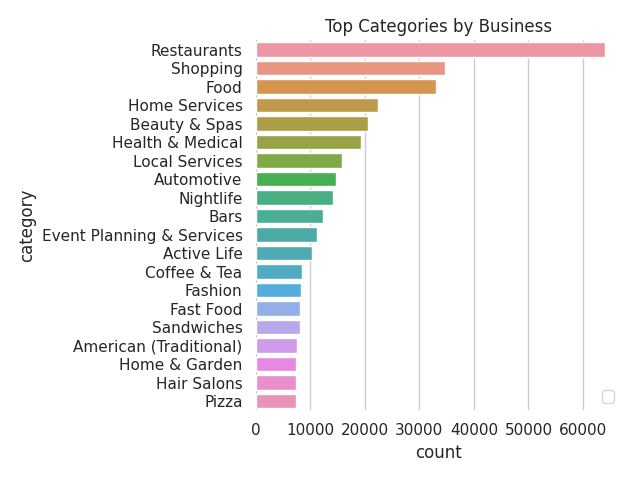

In [14]:
sns.set(style="whitegrid", color_codes=True)
sns.barplot(result_pdf['count'],result_pdf['categories'])    
plt.title('Top Categories by Business')
plt.xlabel('count')
plt.ylabel('category')
plt.tight_layout()
plt.legend('')
plt.box(False)
%matplot plt

# Do Yelp Reviews Skew Negative?

Oftentimes, it is said that the only people who write a written review are those who are extremely _dissatisfied_ or extremely _satisfied_ with the service received. 

How true is this really? Let's try and answer this question.

## Loading User Data

Begin by loading the user data set from S3 and printing schema to determine what data is available.

In [15]:
review=spark.read.json('s3://sta9760f2020-project2-review-dataset/yelp_academic_dataset_review.json')


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
review

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[business_id: string, cool: bigint, date: string, funny: bigint, review_id: string, stars: double, text: string, useful: bigint, user_id: string]

Let's begin by listing the `business_id` and `stars` columns together for the user reviews data.

In [16]:
review.createOrReplaceTempView('YelpReview')
review_sqldf = spark.sql(
'''
SELECT business_id, stars, user_id
FROM YelpReview
'''
)
review_sqldf.select('business_id','stars').show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|         business_id|stars|
+--------------------+-----+
|-MhfebM0QIsKt87iD...|  2.0|
|lbrU8StCq3yDfr-QM...|  1.0|
|HQl28KMwrEKHqhFrr...|  5.0|
|5JxlZaqCnk1MnbgRi...|  1.0|
|IS4cv902ykd8wj1TR...|  4.0|
+--------------------+-----+
only showing top 5 rows

Now, let's aggregate along the `stars` column to get a resultant dataframe that displays _average stars_ per business as accumulated by users who **took the time to submit a written review**.

In [17]:
review_avg=review_sqldf.groupby('business_id').agg({'stars':'mean'})
review_avg.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+
|         business_id|        avg(stars)|
+--------------------+------------------+
|ATeOjZzE3VOI-RW7F...| 3.433734939759036|
|RMjCnixEY5i12Ciqn...|3.5316455696202533|
|vbUABNAQI2iwN7v0x...|2.4545454545454546|
|VHsNB3pdGVcRgs6C3...| 3.411764705882353|
|r-W1HPIZ3V6S2DaXh...| 4.852459016393443|
+--------------------+------------------+
only showing top 5 rows

Now the fun part - let's join our two dataframes (reviews and business data) by `business_id`. 

In [18]:
business_rating =review_avg.join(business, on="business_id", how="inner")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Let's see a few of these:

In [19]:
business_rating.select('avg(stars)', 'stars', 'name', 'city', 'state').show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+-----+--------------------+-----------+-----+
|        avg(stars)|stars|                name|       city|state|
+------------------+-----+--------------------+-----------+-----+
|  4.11784140969163|  4.0|Delmonico Steakhouse|  Las Vegas|   NV|
|2.3333333333333335|  2.5|Neo-Paws Internat...|    Toronto|   ON|
|             4.375|  4.5| McFarling Law Group|  Las Vegas|   NV|
|3.3333333333333335|  3.5|Volvo of Mississauga|Mississauga|   ON|
|               5.0|  5.0|Andre Agassi Coll...|  Las Vegas|   NV|
+------------------+-----+--------------------+-----------+-----+
only showing top 5 rows

Compute a new dataframe that calculates what we will call the _skew_ (for lack of a better word) between the avg stars accumulated from written reviews and the _actual_ star rating of a business (ie: the average of stars given by reviewers who wrote an actual review **and** reviewers who just provided a star rating).

The formula you can use is something like:

```
(row['avg(stars)'] - row['stars']) / row['stars']
```

If the **skew** is negative, we can interpret that to be: reviewers who left a written response were more dissatisfied than normal. If **skew** is positive, we can interpret that to be: reviewers who left a written response were more satisfied than normal.

In [20]:
skewDF = business_rating.withColumn('skew', (business_rating['avg(stars)'] - business_rating['stars']) / business_rating['stars'])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
skewDF.select('skew').describe().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------------------+
|summary|                skew|
+-------+--------------------+
|  count|              209393|
|   mean|0.001235344665268...|
| stddev| 0.05523522538149904|
|    min|-0.45454545454545453|
|    max|  1.3333333333333335|
+-------+--------------------+

In [22]:
skewDFPandas = skewDF.select('skew').toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

And finally, graph it!

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

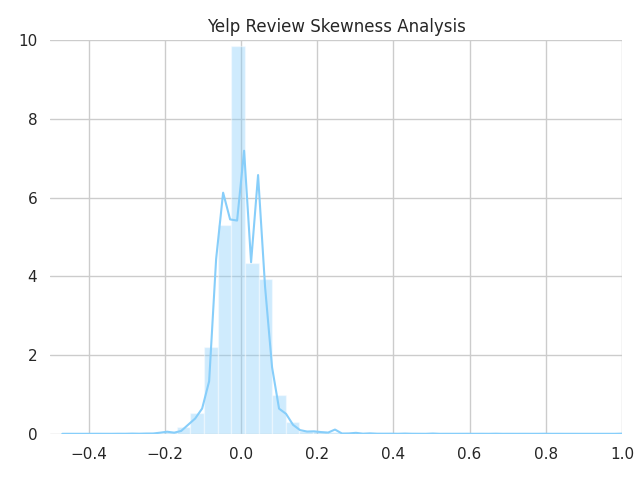

In [23]:
plt.clf()
plt.figure()
ax = sns.distplot(skewDFPandas,color="lightskyblue")
sns.set_style("white")
ax.set_title('Yelp Review Skewness Analysis')
plt.tight_layout()
plt.box(False)
plt.xlim(-0.5, 1)
plt.ylim(0, 10)

%matplot plt

## So, do Yelp (written) Reviews skew negative? Does this analysis actually prove anything? Expound on implications / interpretations of this graph. 


Answer: Most of the pints distributed close to 0 and also We can observer a slightly negative skewness.So we can say,Yelp reviews are slightly negative. But, we also need to look at other variables to support the negative skewness, in order to support this we need to plot review amount vs review stars.

Also we can observe normal distribution pattren here and by this we can conclude most of the datapoints disributed within  1 or 2 standard deviation from the mean. We can also observe there are no outliers in the above graph. 

In [24]:
review.describe().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------------------+------------------+-------------------+------------------+--------------------+------------------+-------------------------------------+------------------+--------------------+
|summary|         business_id|              cool|               date|             funny|           review_id|             stars|                                 text|            useful|             user_id|
+-------+--------------------+------------------+-------------------+------------------+--------------------+------------------+-------------------------------------+------------------+--------------------+
|  count|             8021122|           8021122|            8021122|           8021122|             8021122|           8021122|                              8021122|           8021122|             8021122|
|   mean|                null|0.5745620126461111|               null|0.4596423044057926|                null|3.7035746370644906|                                 null|1.3228

In [25]:
##Top Rated Business

top_rated = spark.sql(
'''
SELECT business_id, count(*) as reviews
FROM YelpReview
WHERE stars=5
GROUP by business_id
ORDER by 2 desc

'''
)
top_rated.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------+
|         business_id|reviews|
+--------------------+-------+
|4JNXUYY8wbaaDmk3B...|   4501|
|RESDUcs7fIiihp38-...|   4247|
|faPVqws-x-5k2CQKD...|   3415|
|vHz2RLtfUMVRPFmd7...|   3290|
|JDZ6_yycNQFTpUZzL...|   3158|
|f4x1YBxkLrZg652xt...|   2848|
|QXV3L_QFGj8r6nWX2...|   2827|
|3kdSl5mo9dWC4clrQ...|   2758|
|DkYS3arLOhA8si5uU...|   2738|
|mDR12Hafvr84ctpsV...|   2661|
+--------------------+-------+
only showing top 10 rows

In [26]:
low_rated=  spark.sql(
'''
SELECT business_id, count(*) as reviews
FROM YelpReview
WHERE stars=1
GROUP by business_id
ORDER by 2 desc

'''
)
low_rated.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------+
|         business_id|reviews|
+--------------------+-------+
|u_vPjx925UPEG9DFO...|   1492|
|AV6weBrZFFBfRGCbc...|   1391|
|6Q7-wkCPc1KF75jZL...|   1360|
|El4FC8jcawUVgw_0E...|   1260|
|e0CTLPxTnFEQSqQ1F...|   1131|
|yhgUyctWczUN13Min...|   1084|
|dWFUKB_HPBIE87AFB...|   1069|
|RESDUcs7fIiihp38-...|   1056|
|o7AiTlyWUrBSzdz6o...|   1021|
|xtYiHTmunjfCN2sUa...|    991|
+--------------------+-------+
only showing top 10 rows

#### It shows high rating firm is associated with high reveiew count. This does not support our conclusion: Yelp reviews are slightly  negative is still true.

In [47]:
stars_reviews = spark.sql(
'''
SELECT stars, count(*) as reviews
FROM YelpReview
GROUP by stars

'''
)
stars_reviews.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+-------+
|stars|reviews|
+-----+-------+
|  1.0|1283897|
|  4.0|1673404|
|  3.0| 842289|
|  2.0| 635072|
|  5.0|3586460|
+-----+-------+

#### Let us see how stars and reviews variable co-related by printing co-relation marix

In [48]:
corrMatrix = stars_reviews.toPandas().corr()
print(corrMatrix)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

            stars   reviews
stars    1.000000  0.757088
reviews  0.757088  1.000000

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

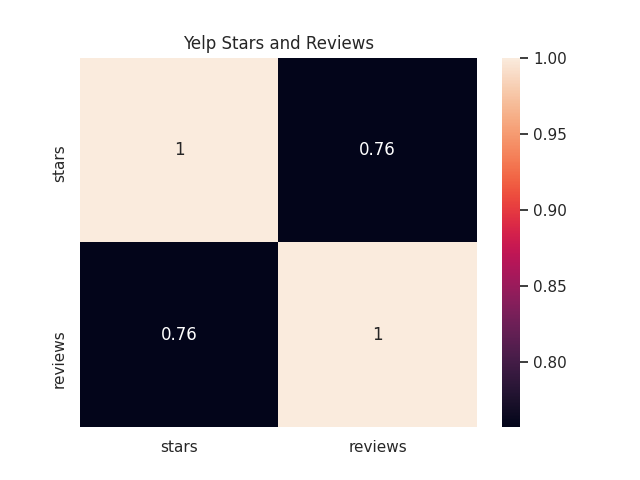

In [49]:
plt.figure()
sns.heatmap(corrMatrix,  annot=True)
plt.title('Yelp Stars and Reviews')
%matplot plt

#### Conclusion:
We see high correlation beween number of reviews and number of stars. People are only bothering to rate good firms that makes it interesting to use Yelp only to determine if the firm is reviewd at all. If the firm is not rated the unwritten reviews are bad. This does not support our conclusion that Yelp reviews are slightly negative

#### Correlation Business and rating

In [54]:
business_rating = spark.sql(
'''
SELECT business_id, avg(stars) as rating
FROM YelpReview
GROUP by business_id
ORDER by 2 desc

'''
)
business_rating.show(5)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------+
|         business_id|rating|
+--------------------+------+
|oPJd4wYJ5xuDB5P0h...|   5.0|
|VJnI8FZ0ljhlCTP6x...|   5.0|
|i42M5aLwhsCSRD0eW...|   5.0|
|I39cfAld_XkZ45EmS...|   5.0|
|LrV3n7iIss51VCWgN...|   5.0|
+--------------------+------+
only showing top 5 rows

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

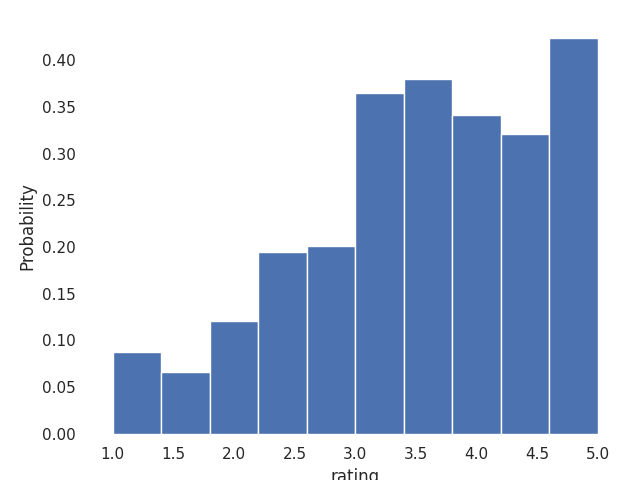

In [55]:
rating_pdf = business_rating.toPandas()
plt.figure()
fig, ax = plt.subplots()
rating_pdf['rating'].plot.hist(density=True, ax=ax)
ax.set_ylabel('Probability')
plt.tight_layout()
plt.xlabel('rating')
plt.box(False)
%matplot plt

### By looking at above Bar graph we can say : Yelp reviews are not completely negative, which gives strong support to our statement.

# Should the Elite be Trusted? (Or, some other analysis of your choice)

For the final portion - you have a choice:

* Try and analyze some interesting dimension to this data. The **ONLY** requirement is that you must use the **Users** dataset and join on either the **business* or **reviews** dataset
* Or, you may try and answer the question posed: how accurate or close are the ratings of an "elite" user (check Users table schema) vs the actual business rating.

Feel free to use any and all methodologies at your disposal - only requirement is you must render one visualization in your analysis

In [56]:
user=spark.read.json('s3://sta9760f2020-project2-review-dataset/yelp_academic_dataset_user.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [57]:
print(f'Total Columns: {len(user.dtypes)}')
print(f'Total Rows: {user.count():,}')
user.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Columns: 22
Total Rows: 1,968,703
root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)

In [70]:
review_compare=review_avg.join(review_sqldf, on="business_id", how="inner")
review_compare.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----------------+-----+--------------------+
|         business_id|      avg(stars)|stars|             user_id|
+--------------------+----------------+-----+--------------------+
|--9e1ONYQuAa-CB_R...|4.11784140969163|  5.0|mBBGHMLDDmtptNIu0...|
|--9e1ONYQuAa-CB_R...|4.11784140969163|  4.0|5WBIwR92ZNVmsG7bR...|
|--9e1ONYQuAa-CB_R...|4.11784140969163|  5.0|3HG4RGeej4dZiMo5s...|
|--9e1ONYQuAa-CB_R...|4.11784140969163|  3.0|bWJWcQyDKtFSvsTW2...|
|--9e1ONYQuAa-CB_R...|4.11784140969163|  5.0|HaqStKX7oqpx5ymDH...|
+--------------------+----------------+-----+--------------------+
only showing top 5 rows

In [71]:
user_review_compare=review_compare.join(user, on="user_id", how="inner")
user_review_compare=user_review_compare.select('avg(stars)','stars', 'elite','review_count')
user_review_compare.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+-----+--------------------+------------+
|        avg(stars)|stars|               elite|review_count|
+------------------+-----+--------------------+------------+
|            4.0125|  4.0|                    |          55|
| 2.310344827586207|  2.0|                    |           3|
|2.9904761904761905|  4.0|2011,2012,2013,20...|         163|
|2.8392857142857144|  1.0|                    |           7|
|3.3636363636363638|  5.0|                    |           7|
+------------------+-----+--------------------+------------+
only showing top 5 rows

In [72]:
review_skew = user_review_compare.withColumn("skew", F.round((F.col('avg(stars)')-F.col('stars'))/F.col('stars'), 2))
review_skew.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+-----+--------------------+------------+-----+
|        avg(stars)|stars|               elite|review_count| skew|
+------------------+-----+--------------------+------------+-----+
|            4.0125|  4.0|                    |          55|  0.0|
| 2.310344827586207|  2.0|                    |           3| 0.16|
|2.9904761904761905|  4.0|2011,2012,2013,20...|         163|-0.25|
|3.5925925925925926|  1.0|                    |           7| 2.59|
|2.8392857142857144|  1.0|                    |           7| 1.84|
+------------------+-----+--------------------+------------+-----+
only showing top 5 rows

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

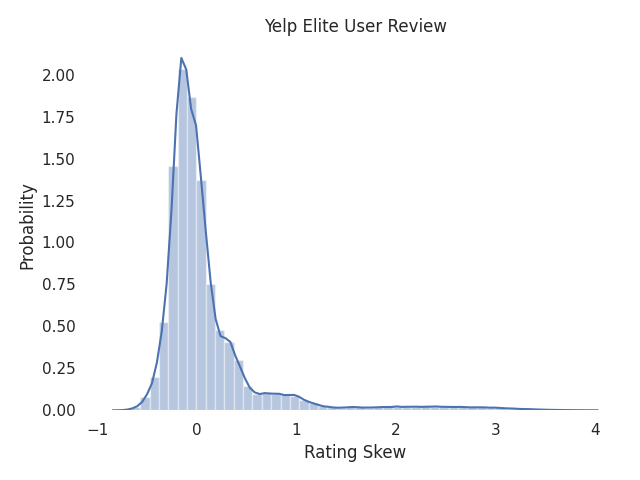

In [73]:
elite_review_skew=review_skew.filter(F.col('elite')!='')
result_pdf = elite_review_skew.toPandas()
plt.figure()
sns.distplot(result_pdf['skew'])    
plt.title('Yelp Elite User Review')
plt.xlabel('Rating Skew')
plt.ylabel('Probability')
plt.tight_layout()
plt.box(False)
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

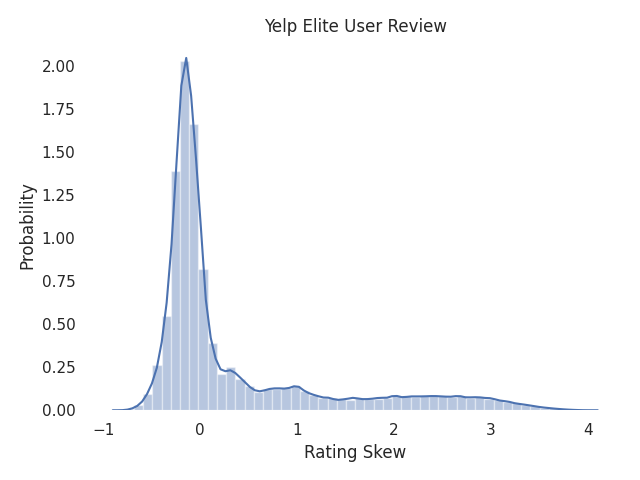

In [74]:
non_elite_review_skew=review_skew.filter(F.col('elite')=='')
result_pdf = non_elite_review_skew.toPandas()
plt.figure()
sns.distplot(result_pdf['skew'])    
plt.title('Yelp Elite User Review')
plt.xlabel('Rating Skew')
plt.ylabel('Probability')
plt.tight_layout()
plt.box(False)
%matplot plt

#### Conclusion: It seems that there is no significant difference in the skewness of the reviews of elite users compared to normal user.
    